# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # recent 5 year maybe corrupted
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # high initial data
# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # corrupted
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt"  
# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt" # hard to fit
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt" # truncate
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # truancate dataset, try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # has 0 speed records
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem, weird direction distribution

# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt"
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # 16 sectors

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # 
# ipath= "./data/NCDC/cn/luogang/dat.txt"  # 
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # chi square 有问题
# ipath= "./data/NCDC/cn/wusu/dat.txt" # chi square 有问题, bandwidth 过小
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # 
ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" # good
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real
# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # Wrong data

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,2.813470e+05,281347.000000,281347.00000,281347.000000,281347.000000
mean,2.001544e+07,1106.450579,181.14116,3.947066,158.748975
std,9.786473e+04,681.443079,114.82452,1.800596,107.843629
min,1.980010e+07,0.000000,0.00000,0.500000,0.000000
25%,1.993113e+07,500.000000,80.00000,3.000000,70.000000
50%,2.003082e+07,1100.000000,160.00000,4.000000,140.000000
75%,2.010111e+07,1700.000000,300.00000,5.000000,250.000000
max,2.015030e+07,2357.000000,359.00000,30.000000,350.000000


False


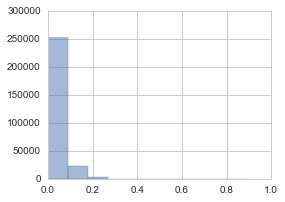

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

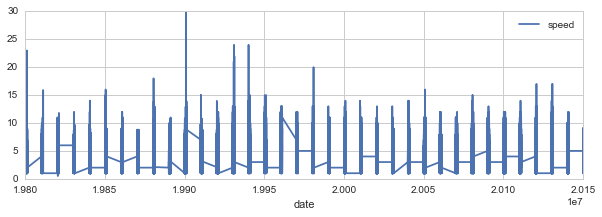

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

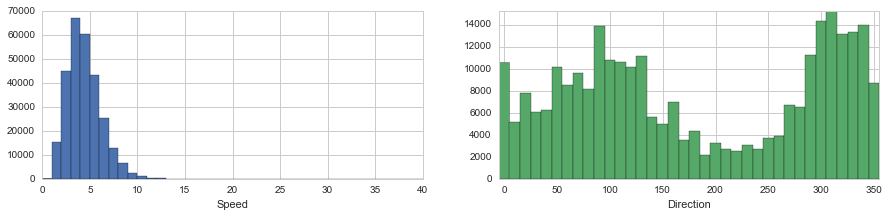

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,
19940128,19940128,0,FM-15,119,3.0,331,0.0
19940718,19940718,1000,FM-15,337,5.0,113,0.0
19940805,19940805,1100,FM-15,335,9.0,115,0.0
19940810,19940810,500,FM-15,319,10.0,131,0.0
19940903,19940903,2100,FM-15,331,5.0,119,0.0
19941203,19941203,1400,FM-15,316,3.0,134,0.0
19950403,19950403,1300,FM-15,337,3.0,113,0.0
19980603,19980603,1100,FM-15,59,10.0,31,0.0
19980909,19980909,1200,FM-15,359,20.0,91,0.0


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19900917,19900917,0,SY-MT,130,30.0,320,0.0,27.9,24.9
19931012,19931012,2300,FM-16,320,24.0,130,0.0,22.0,20.0
19940127,19940127,2300,FM-16,170,24.0,280,0.0,21.0,20.0
19801008,19801008,2100,FM-12,0,23.0,90,0.0,21.0,19.0
19931221,19931221,2200,FM-15,110,22.0,340,0.0,19.0,20.0
19800714,19800714,900,FM-12,280,22.0,170,0.0,20.0,20.0
19930802,19930802,1400,FM-15,140,21.0,310,0.0,17.0,19.0
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0


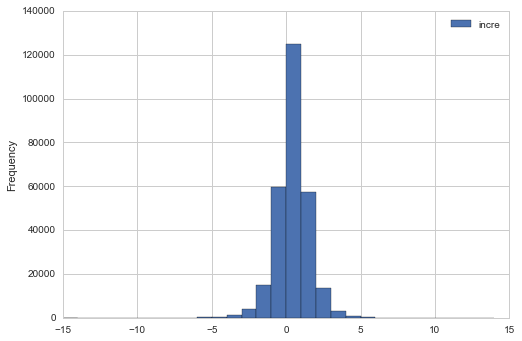

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 9


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20120808,20120808,530,FM-15,0,17.0,90,0.0,2.0,4.0
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0
19850430,19850430,800,FM-15,310,16.0,140,0.0,9.8,11.0
20050911,20050911,1700,FM-15,0,16.0,90,0.0,4.0,4.0
19811219,19811219,700,FM-15,140,15.9,310,0.9,7.9,3.1
19811219,19811219,500,SY-MT,140,15.9,310,0.9,7.9,7.9
19850312,19850312,900,SY-MT,0,15.0,90,0.0,9.9,10.9
19910209,19910209,600,SY-MT,200,15.0,250,0.0,10.9,9.9


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0      10555
10      5130
20      7804
30      6064
40      6251
50     10110
60      8530
70      9575
80      8128
90     13902
100    10757
110    10636
120    10161
130    11167
140     5624
150     4938
160     6934
170     3546
180     4387
190     2173
200     3221
210     2703
220     2529
230     3030
240     2716
250     3684
260     3877
270     6740
280     6489
290    11213
300    14350
310    15205
320    13146
330    13326
340    13999
350     8728
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

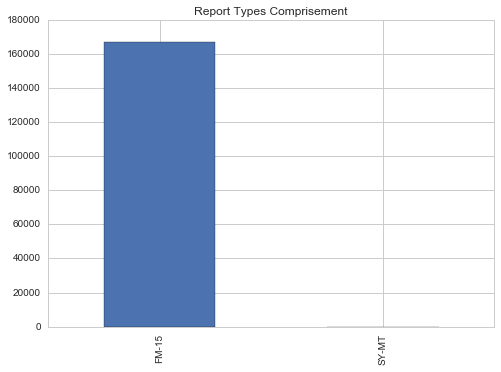

In [14]:
df.query('date > 20000000')['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query('date > 20000000')['type'].value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

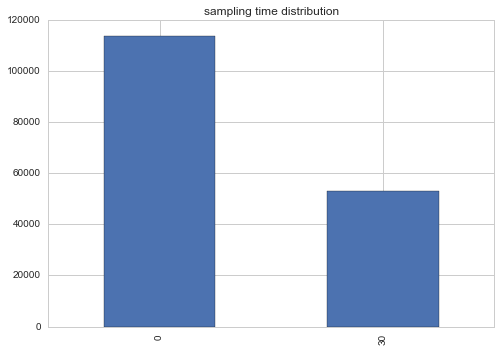

In [15]:
df['sample_time'] = df.HrMn % 100 
df.query('date > 20000000')['sample_time'].value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = df.query('date > 20000000')['sample_time'].value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0       7027
100     8319
200     8613
300     7538
400     8951
500     8956
600     7690
700     9245
800     9308
900     7970
1000    8956
1100    8634
1200    7622
1300    8263
1400    7913
1500    6972
1600    7328
1700    7150
1800    6498
1900    6973
2000    6956
2100    6562
2200    7283
2300    7508
Name: HrMn, dtype: int64

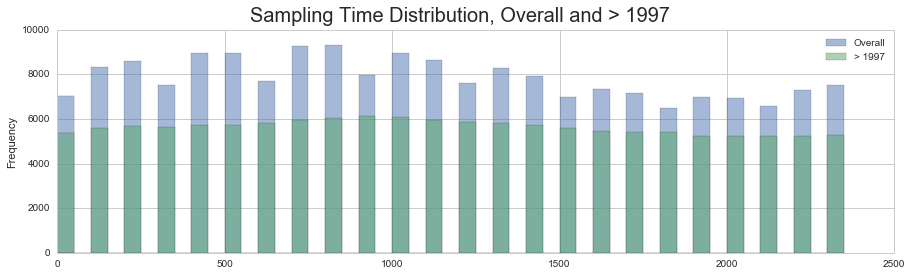

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

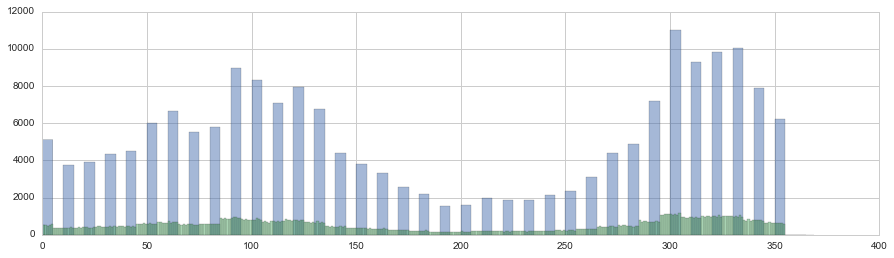

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

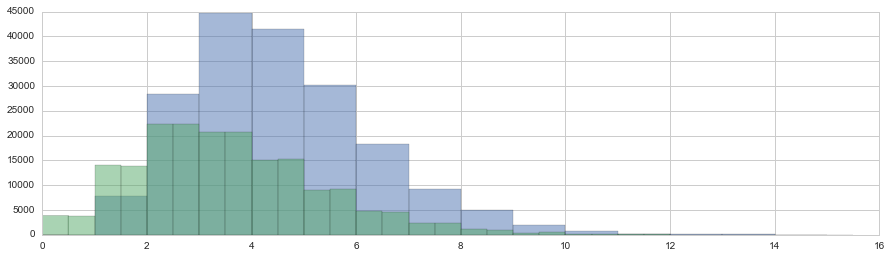

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

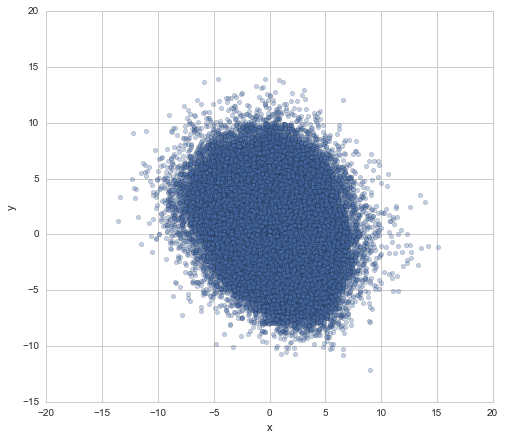

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

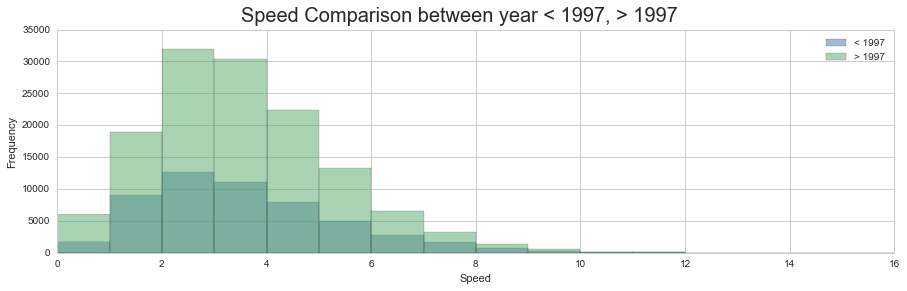

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

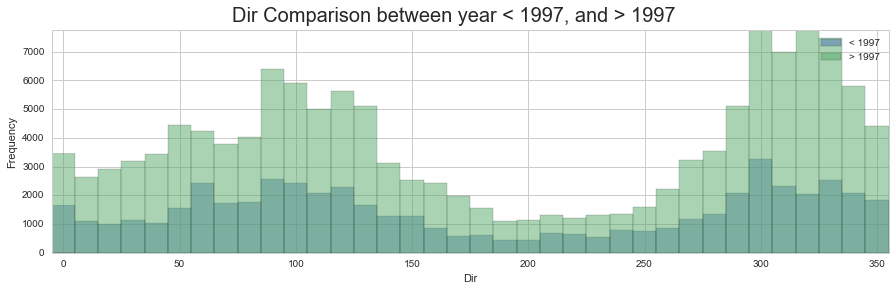

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

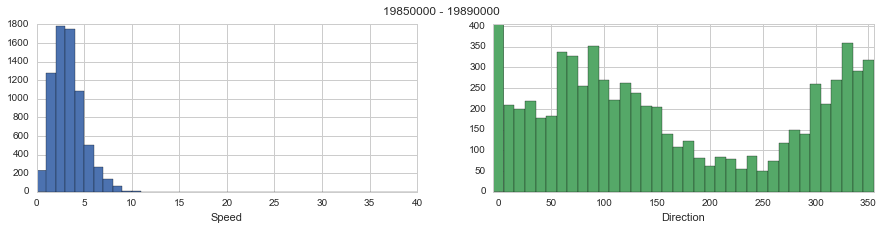

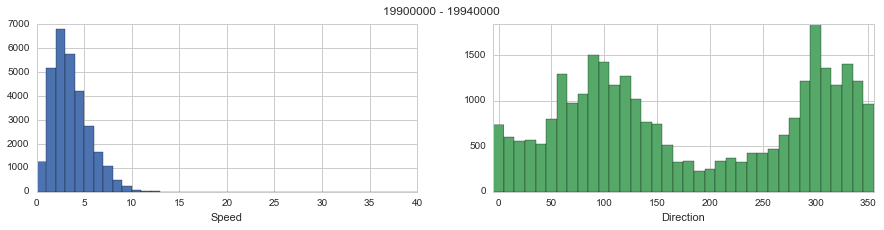

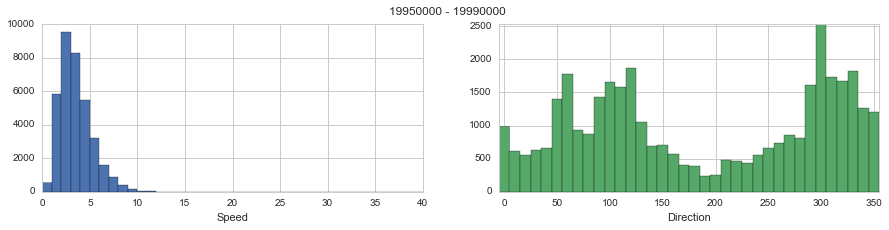

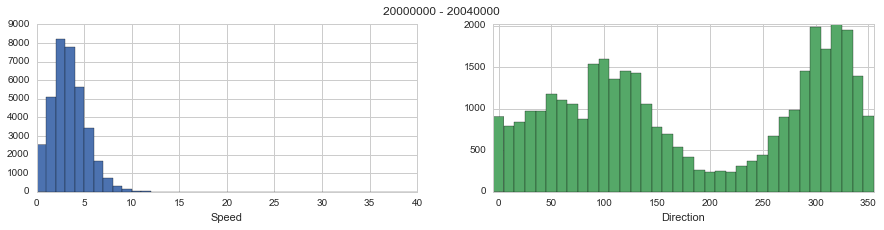

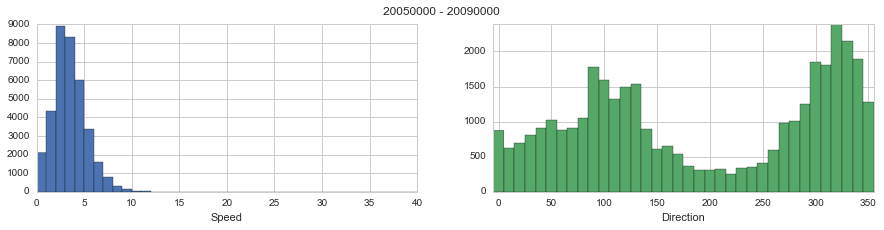

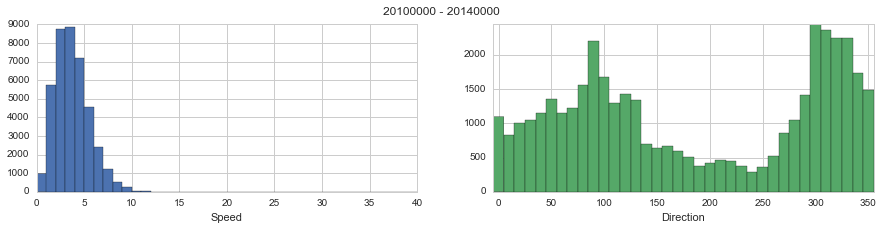

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 10
Report type used: FM-15
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,4.057000e+04,40570.000000,40570.000000,40570.000000,40570.000000,40570.0,40570.000000,40570.000000,40570.000000,40570.000000
mean,2.012083e+07,1137.670693,184.950240,3.749694,152.993098,0.0,0.008578,0.008430,0.884395,0.377171
std,1.407122e+04,685.007356,115.993861,1.833294,106.550156,0.0,0.886869,0.897068,2.525552,3.180986
min,2.010010e+07,0.000000,-4.979039,0.001705,0.000000,0.0,-9.000000,-12.000000,-11.478088,-10.178959
25%,2.011041e+07,600.000000,83.144809,2.393091,70.000000,0.0,0.000000,0.000000,-0.641435,-1.900748
50%,2.012071e+07,1100.000000,163.625725,3.542033,130.000000,0.0,0.000000,0.000000,1.159712,0.099063
75%,2.013093e+07,1700.000000,304.699888,4.850962,230.000000,0.0,1.000000,1.000000,2.675997,2.696044
max,2.014123e+07,2300.000000,354.970328,14.263002,350.000000,0.0,8.000000,8.000000,14.224821,13.652065


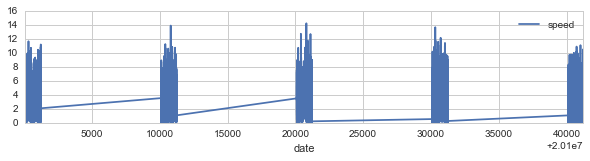

In [27]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

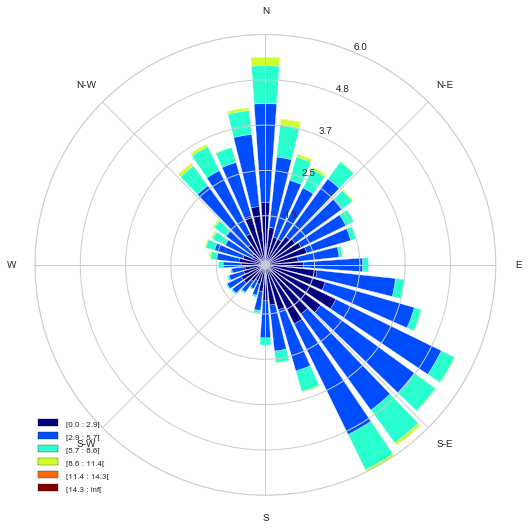

In [28]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

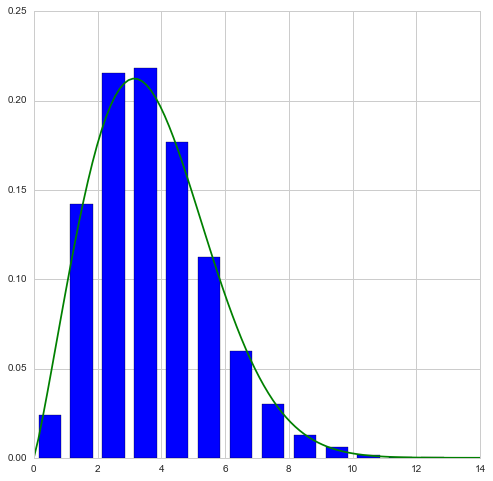

In [29]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

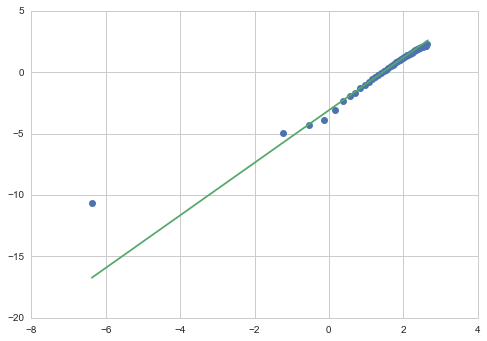

In [30]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [31]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7

In [32]:
FITTING_RANGE = []
fit_limit = ceil(df['speed'].quantile(.95))
plot_limit = ceil(df['speed'].quantile(.975))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])
        
print fitting_axis_range

[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]


# 3. Kernel Density Estimation

In [33]:
sample = SPEED_SET

In [34]:
# # The bandwidth value sometimes would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV

# if knot_unit:
#     bandwidth_range = arange(0.5,2,0.2)
# else:
#     bandwidth_range = arange(0.4,1,0.1)

# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': bandwidth_range},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# bandwidth = grid.best_params_['bandwidth']

In [35]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH 

kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 0.7 289
[  4.61112830e-10   9.03743012e-09   9.55931833e-08   1.41489192e-06
   9.18919879e-06]


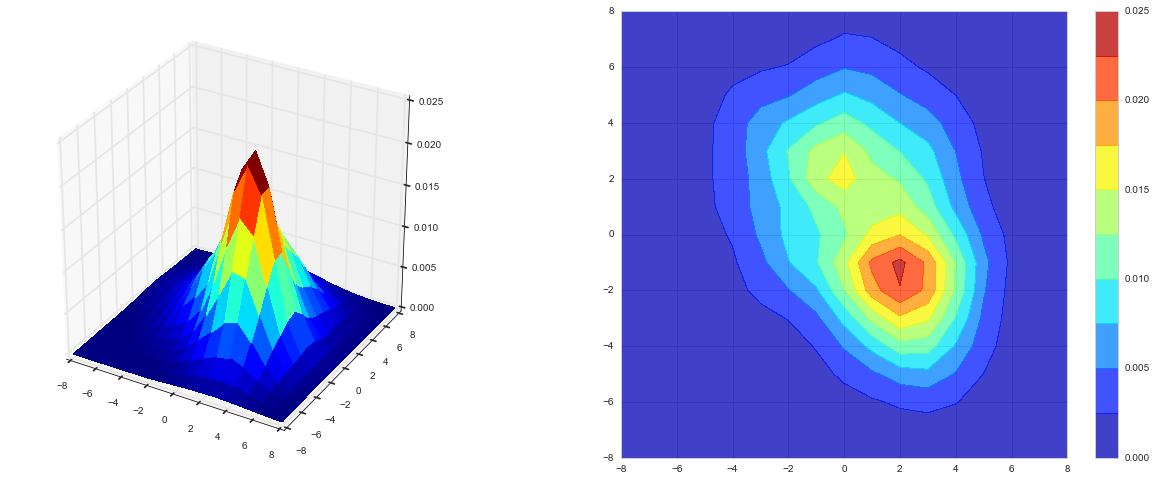

In [36]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [37]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [38]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [39]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.409701,2.081313,-1.811012,1.663033,2.205781,-0.231684
1,0.301805,1.443528,2.542125,2.171754,2.788498,-0.212216
2,0.288495,-1.400318,1.219843,2.380965,2.760324,-0.245259


GMM Plot Result
0.409700524791 [[ 2.08131334 -1.81101212]] [ 1.56996981  2.27295994] -160.505047292
0.301804955651 [[ 1.44352802  2.54212499]] [ 2.06113717  2.87122824] -159.981596703
0.288494519559 [[-1.40031821  1.21984272]] [ 2.18180025  2.92029617] -150.586963718


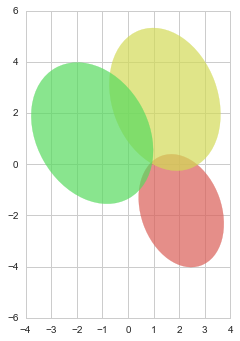

In [40]:
plot_gmm_ellipses(gmm_em_result)

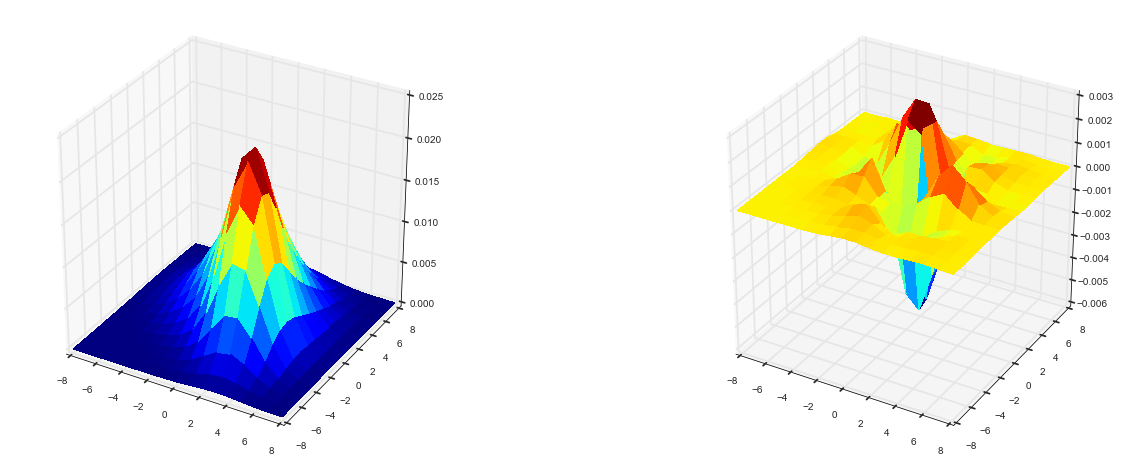

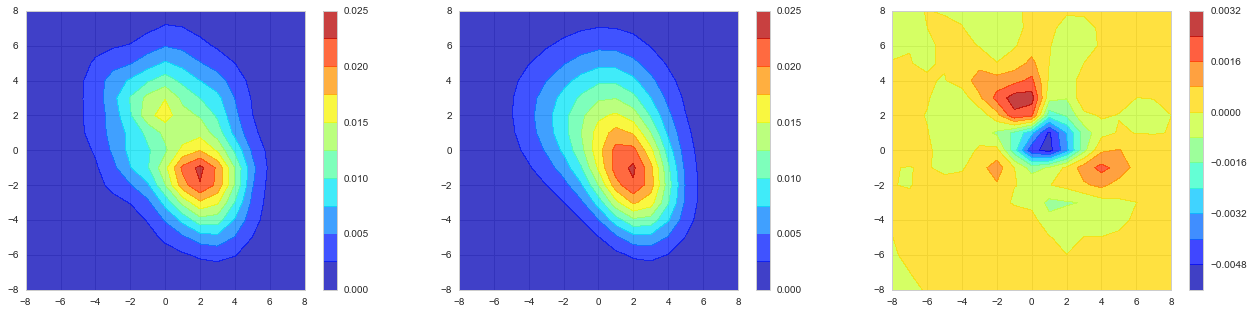

In [41]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [42]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021141,0.02659,6.335816e-07,0.034295,0.232172,0.973061


# 5. Least Square Prob Estimation

In [43]:
sample = SPEED_SET
points = FITTING_RANGE

In [44]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
        # {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        # {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

# bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points,FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -15.474548409084758
     jac: array([  1.64025664e+00,  -1.19209290e-07,   1.19209290e-07,
         5.96046448e-07,   3.57627869e-07,   9.53674316e-07,
         1.64025474e+00,   1.78813934e-06,   2.38418579e-07,
         9.53674316e-07,   4.76837158e-07,   7.15255737e-07,
         1.64025807e+00,   2.38418579e-07,   4.76837158e-07,
         1.19209290e-07,  -2.38418579e-07,  -3.57627869e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1027
     nit: 50
    njev: 50
  status: 0
 success: True
       x: array([ 0.43605499, -0.46690875,  2.10833549,  2.42515132,  3.06779446,
        0.2161298 ,  0.46210126,  2.25792828, -1.75815729,  1.71287335,
        2.08377531, -0.0525327 ,  0.10184374,  0.29843847,  3.03486089,
        3.24782277,  1.23540754, -0.20511057])

## 5.1 GMM Result

In [45]:
kde_result[:5]

array([  4.61112830e-10,   9.03743012e-09,   9.55931833e-08,
         1.41489192e-06,   9.18919879e-06])

In [46]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.462101,2.257928,-1.758157,1.712873,2.083775,-0.052533
1,0.436055,-0.466909,2.108335,2.425151,3.067794,0.216130
2,0.101844,0.298438,3.034861,3.247823,1.235408,-0.205111


GMM Plot Result
0.462101264978 [[ 2.25792828 -1.75815729]] [ 1.70569532  2.08965503] -172.544014689
0.436054993979 [[-0.46690875  2.10833549]] [ 2.29319028  3.16764898] 158.832708444
0.101843741043 [[ 0.29843847  3.03486089]] [ 1.20489634  3.25926516] -95.1695707496


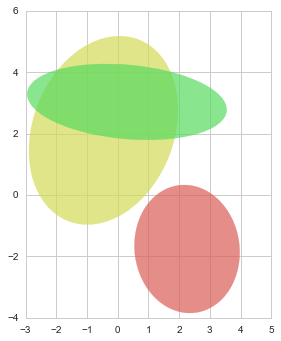

In [47]:
plot_gmm_ellipses(gmm)

## 5.2 Goodness-of-fit indicators

In [48]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021438,0.009386,1.903220e-07,0.018797,0.127249,0.991908


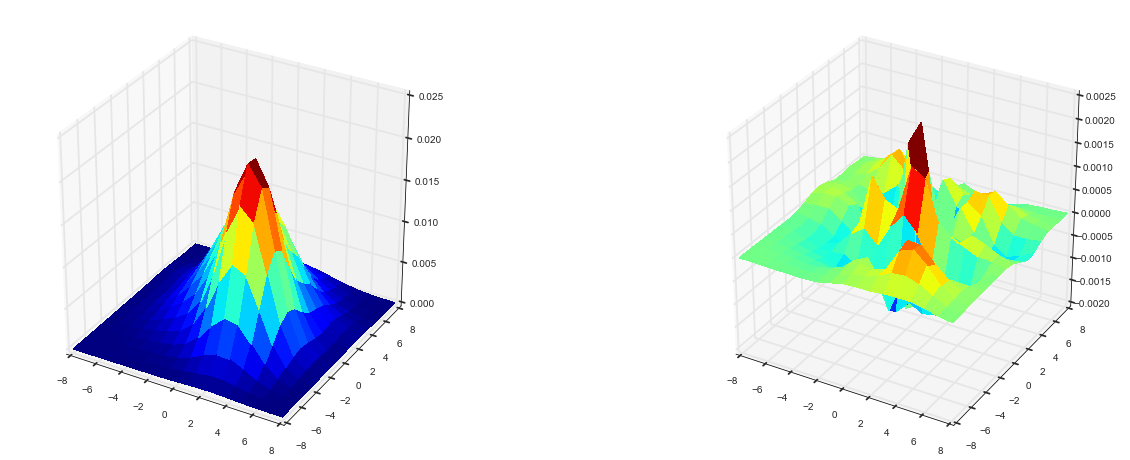

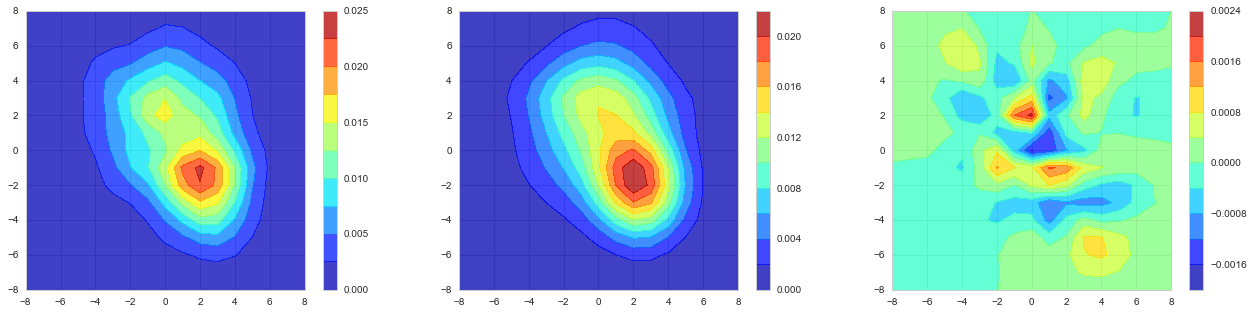

In [49]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [50]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

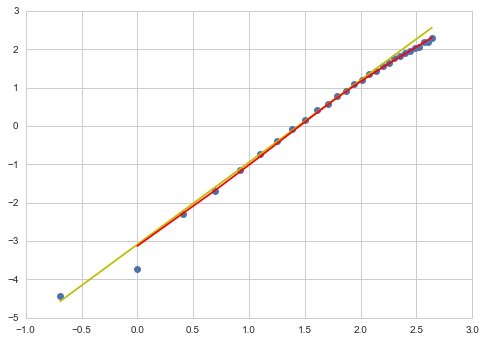

In [51]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

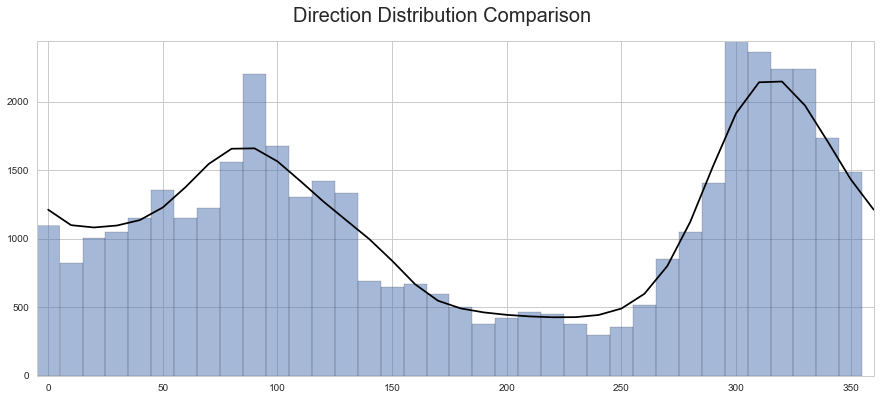

In [52]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

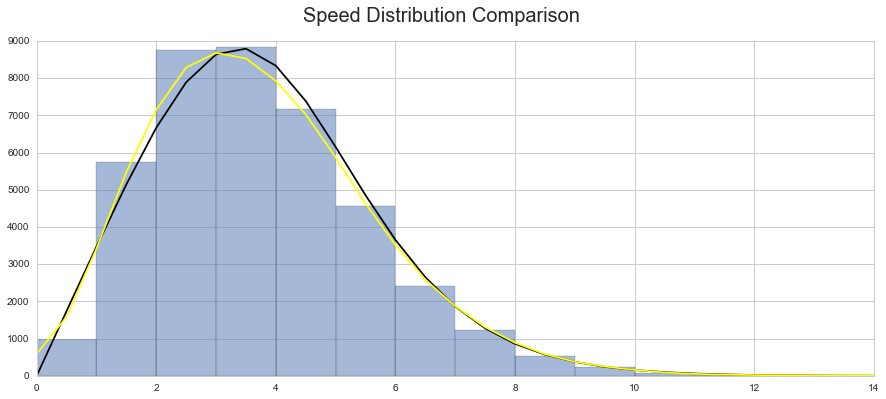

In [53]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

## 5.3 Angle-wise Comaprison

In [54]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = arange(0, sub_max_speed, 0.2)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x =arange(0, sub_max_speed, 0.5)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,3,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. Weibull plot
        ax4 = fig.add_subplot(1,3,3)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'data size:', len(sub_df)
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

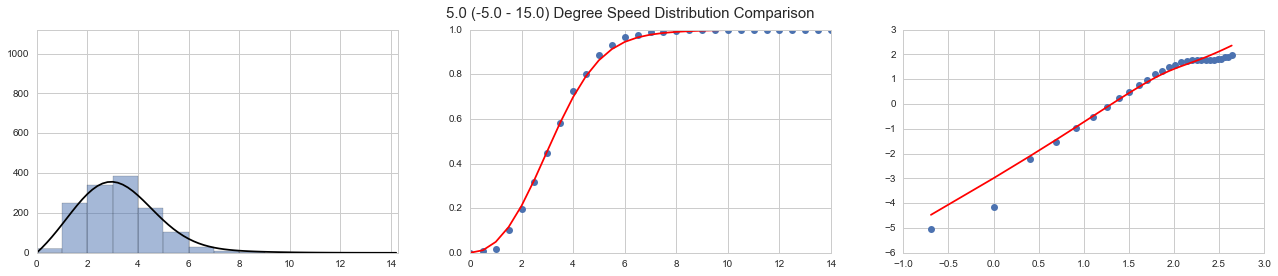

data size: 1371
max diff: 0.0335709621509 , speed value: 1.0 y gmm 0.0488882488029

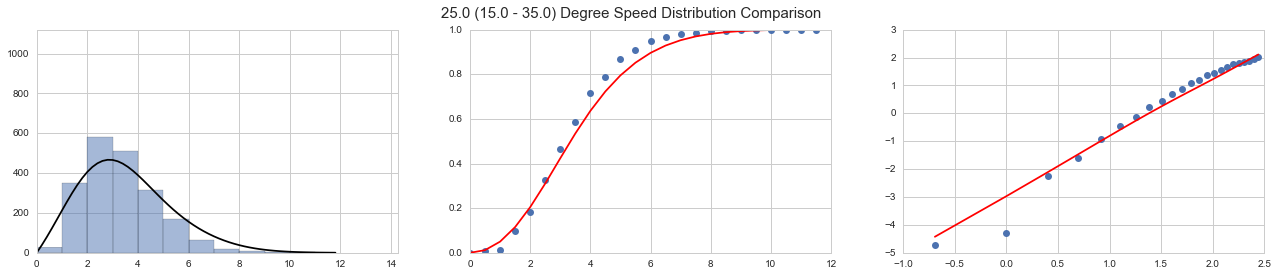

 data size: 2053
max diff: 0.0794271914578 , speed value: 4.0 y gmm 0.635623953208

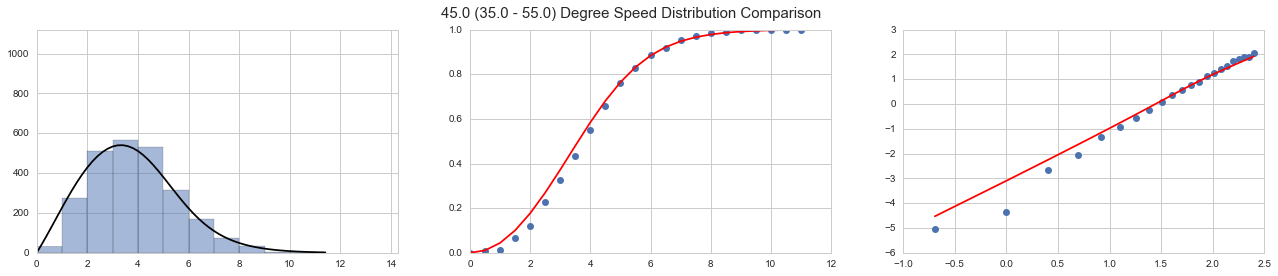

 data size: 2513
max diff: 0.0546804571477 , speed value: 2.0 y gmm 0.176845200482

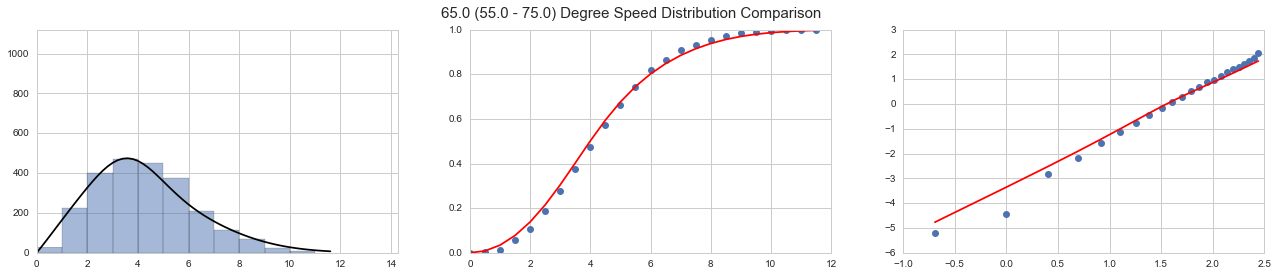

 data size: 2379
max diff: 0.031504465524 , speed value: 2.0 y gmm 0.138272014914

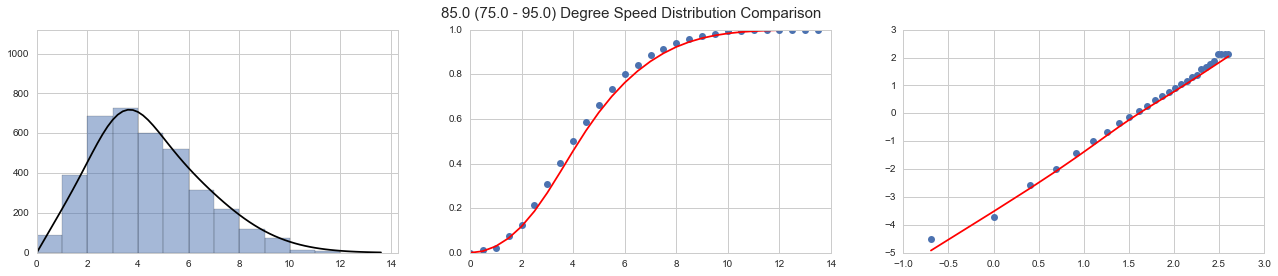

 data size: 3763
max diff: 0.0454543229525 , speed value: 4.0 y gmm 0.456804513083

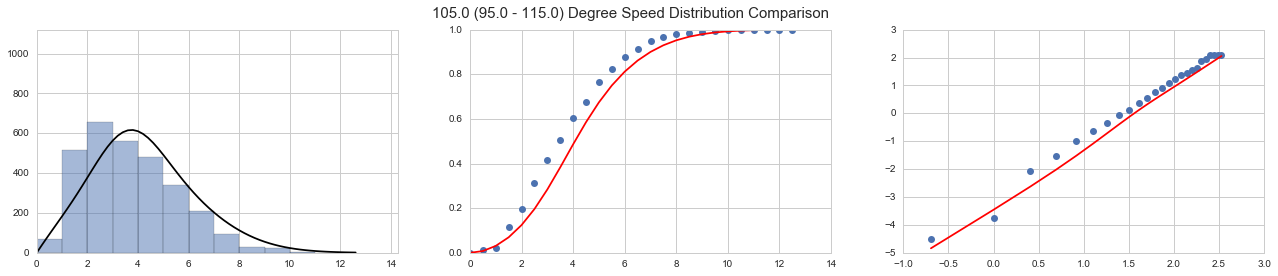

 data size: 2980
max diff: 0.131320656656 , speed value: 3.0 y gmm 0.283780014485

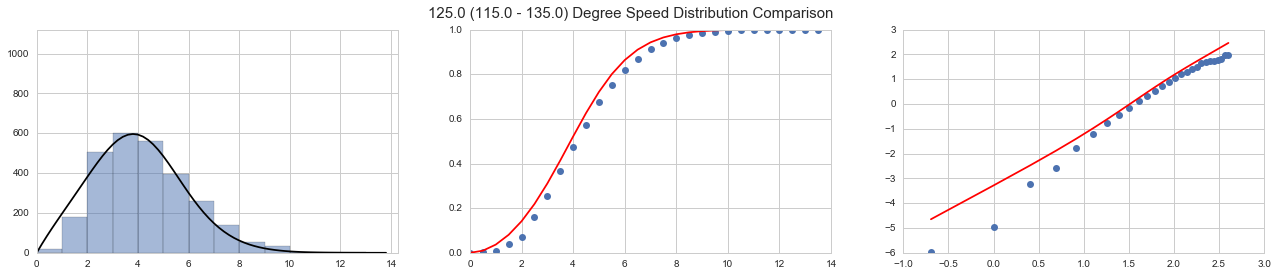

 data size: 2760
max diff: 0.0685031559295 , speed value: 2.0 y gmm 0.141329242886

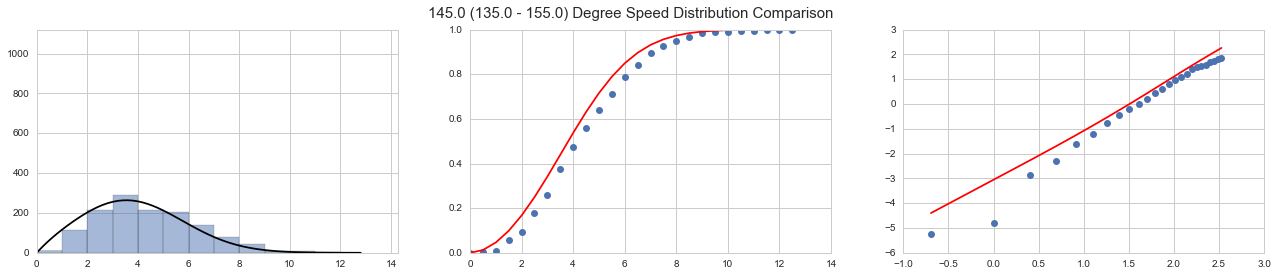

 data size: 1336
max diff: 0.0844148236594 , speed value: 3.0 y gmm 0.341151350606

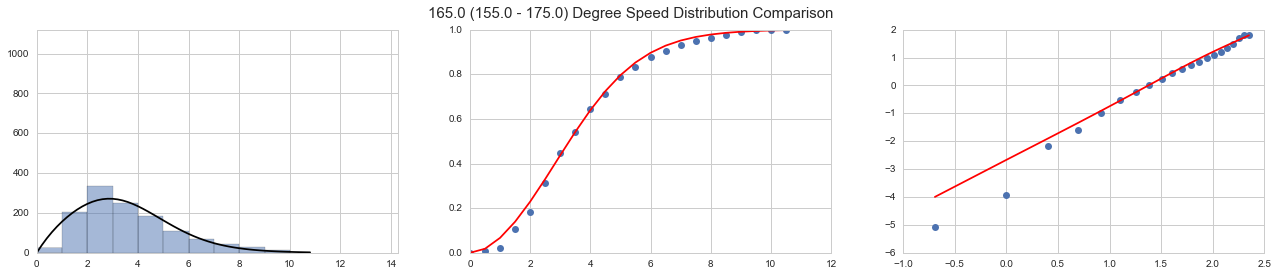

 data size: 1271
max diff: 0.0473888011962 , speed value: 2.0 y gmm 0.229135457372

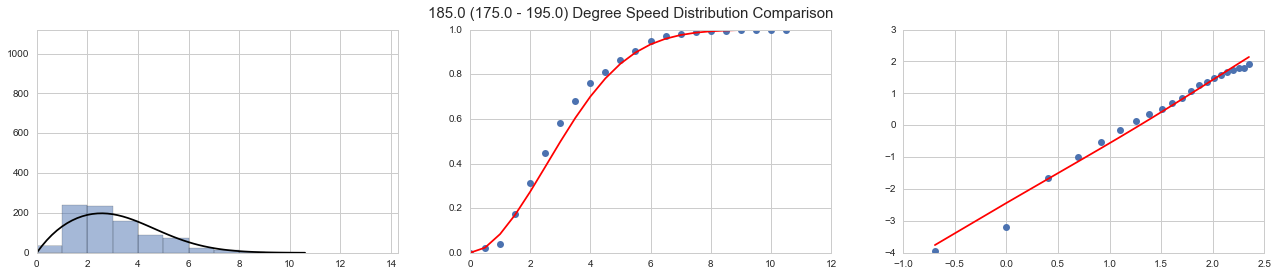

 data size: 876
max diff: 0.0849449885415 , speed value: 3.0 y gmm 0.49724679228

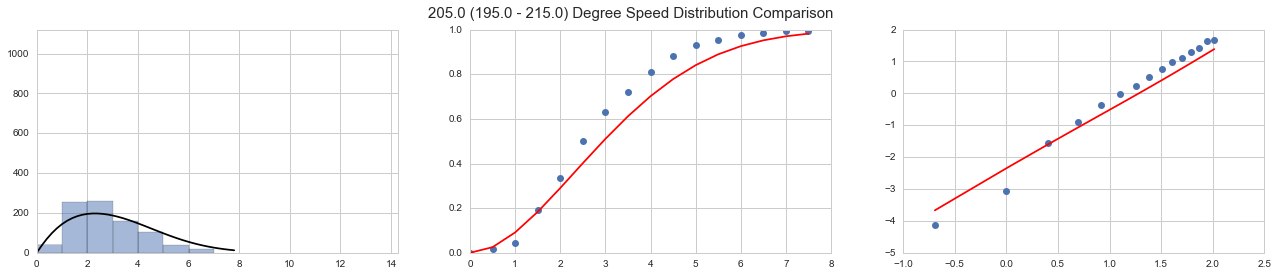

 data size: 885
max diff: 0.119126208576 , speed value: 3.0 y gmm 0.510252322497

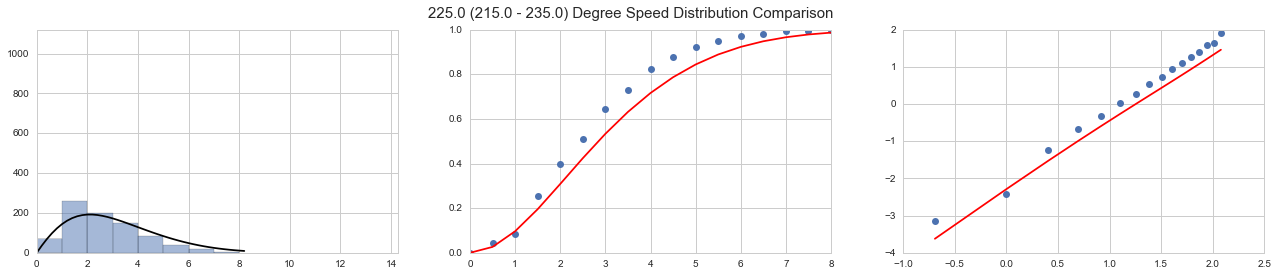

 data size: 828
max diff: 0.109453569527 , speed value: 3.0 y gmm 0.533058507768

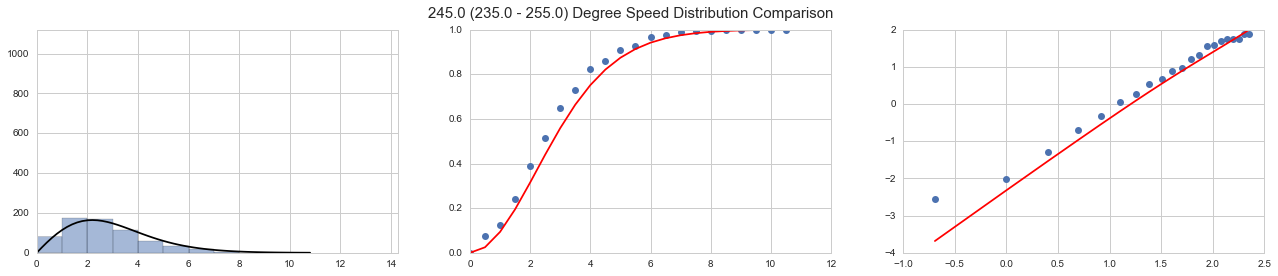

 data size: 655
max diff: 0.0902111059653 , speed value: 3.0 y gmm 0.558643855867

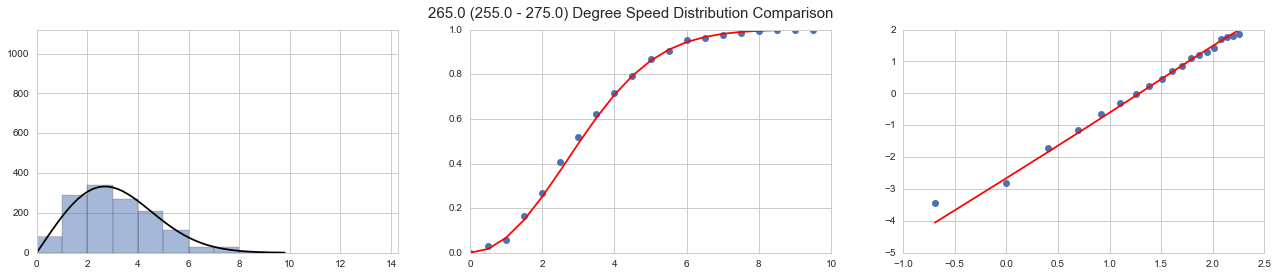

 data size: 1371
max diff: 0.0389968430662 , speed value: 2.5 y gmm 0.368005345118

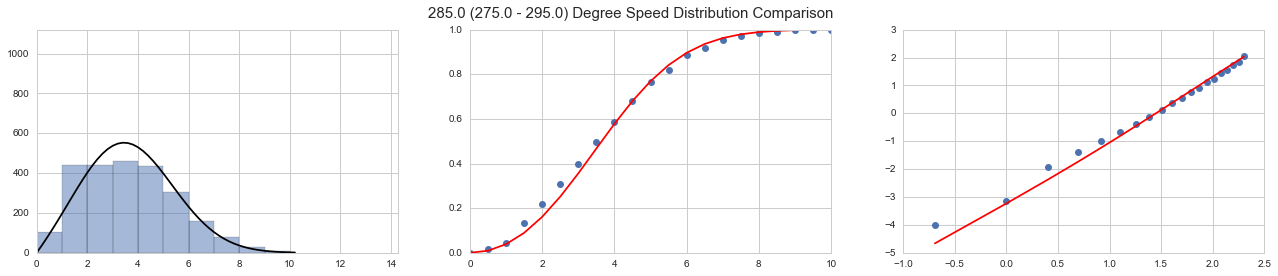

 data size: 2464
max diff: 0.0592851925559 , speed value: 2.0 y gmm 0.161088184067

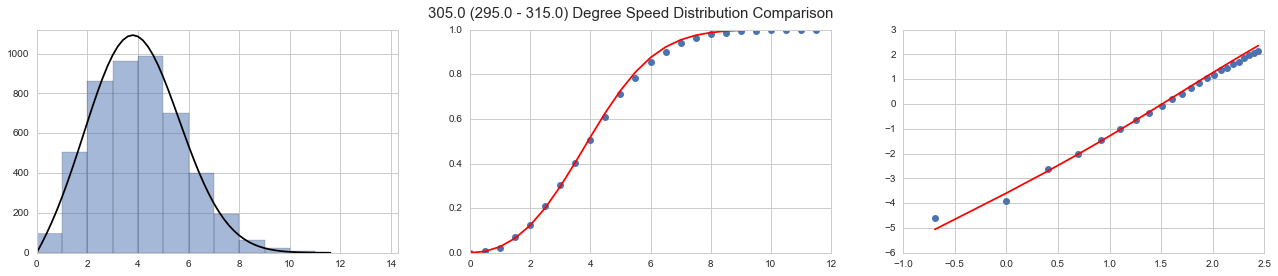

 data size: 4812
max diff: 0.0269442376797 , speed value: 5.5 y gmm 0.809778817896

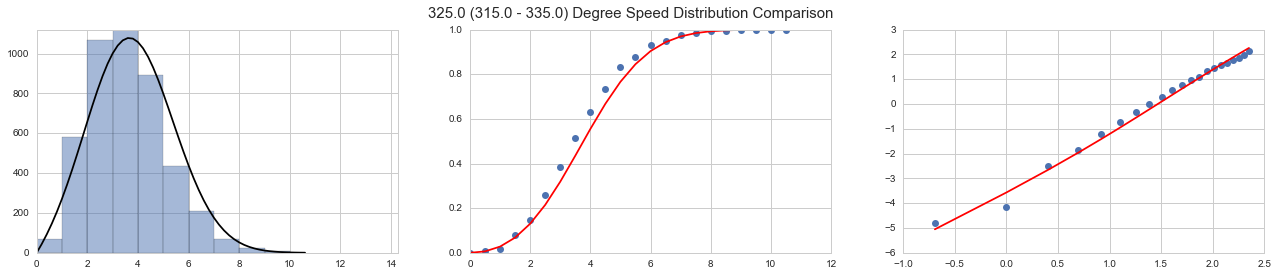

 data size: 4485
max diff: 0.0783771000709 , speed value: 4.0 y gmm 0.554621785102

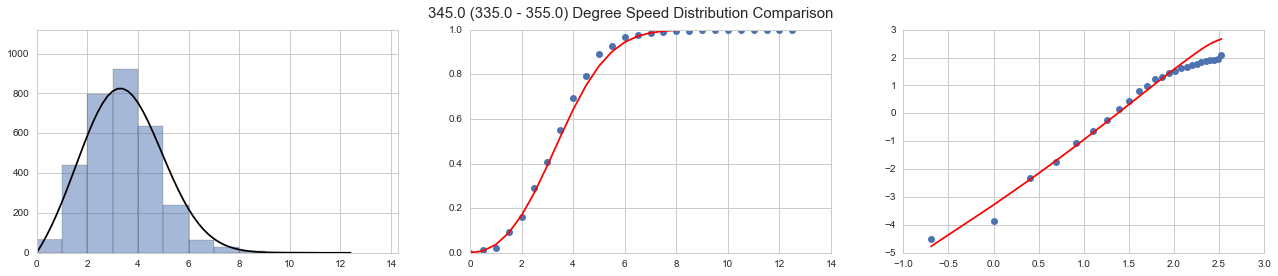

 data size: 3218
max diff: 0.0539528425783 , speed value: 5.0 y gmm 0.836662446421


In [55]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

### 5.3.1 Variance over the years

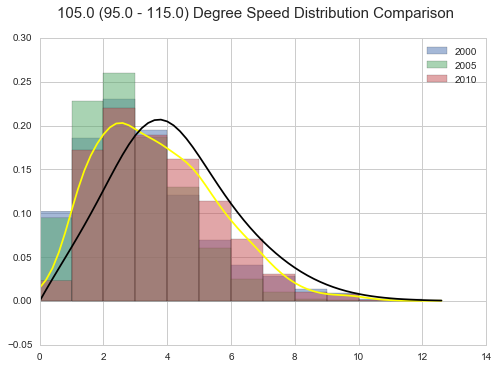

In [66]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.2)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), normed=True,
                                              alpha=0.5,
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

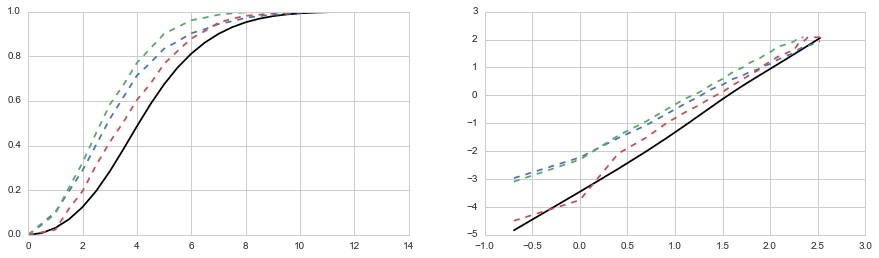

In [67]:
fig = plt.figure(figsize=(15,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,2,1) 
        plt.plot(x, y_cdf,'--')

        ax3 = fig.add_subplot(1,2,2) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--')

### 5.3.2 Bootstrap, to see the variance of each sector

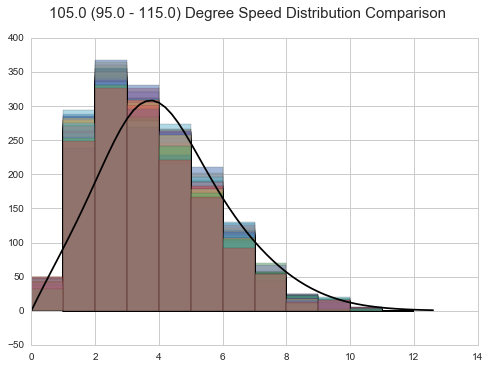

In [68]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.2)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2 * FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5)

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.128019110202 4.0 0.486074849529


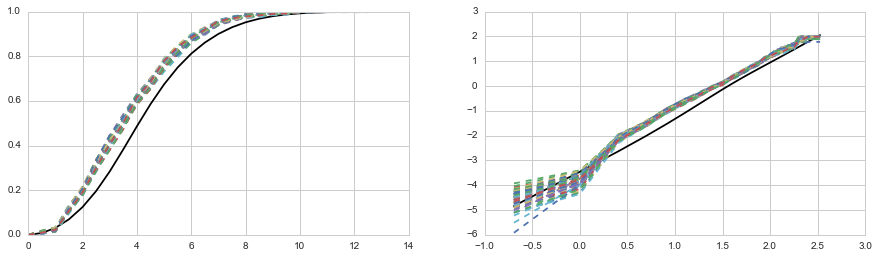

In [69]:
fig = plt.figure(figsize=(15,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,2,1) 
    plt.plot(x, y_cdf,'--')

    ax3 = fig.add_subplot(1,2,2) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# 6. Variance of results & Cross Validation

In [60]:
from sklearn.cross_validation import train_test_split, KFold

if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
    
points = FITTING_RANGE
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error'):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))
    
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. GMM fitting
    x0 = gmm_em_result
#     bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    bonds = [(0., 0.99),(-fit_limit, fit_limit),
             (-fit_limit, fit_limit),(0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
#             {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#             {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
           ]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, points, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_clf': kde,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

## 6.1 Variance of the Result

GMM Plot Result
0.477804557205 [[ 2.2488665  -1.67219378]] [ 1.70340434  2.10501604] -175.908518047
0.404426120632 [[-0.60452788  2.1279091 ]] [ 2.18383564  3.13589788] 159.274799528
0.117769322163 [[ 0.31306712  3.15335581]] [ 1.31539858  3.4219675 ] -92.5479371161


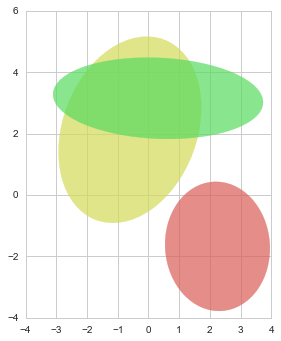

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022933,0.008987,1.759410e-07,0.017753,0.122279,0.992552


GMM Plot Result
0.56784766264 [[ 0.03590541  1.85922795]] [ 2.77974441  3.11469075] 168.513247155
0.383776468205 [[ 2.28449743 -1.94865177]] [ 1.64665198  2.02491299] -168.062564967
0.0483758691548 [[-0.32578802  2.86449159]] [ 0.98355145  1.78109015] -91.154807842


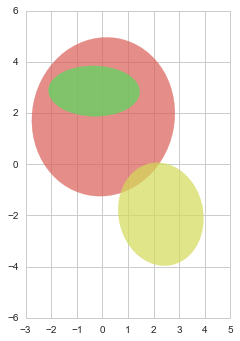

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.018043,0.008879,1.691052e-07,0.018153,0.119928,0.992743


GMM Plot Result
0.505706720054 [[ 2.17970756 -1.682188  ]] [ 1.73974328  2.16304766] -170.74643557
0.348445652564 [[-0.68620386  2.21046505]] [ 1.97717929  3.27297945] 157.097319923
0.145847627382 [[ 0.16835718  3.10223421]] [ 1.36943525  3.45117683] -93.6826882592


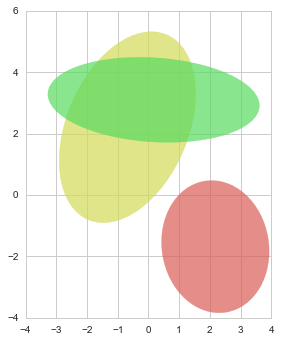

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.023354,0.008677,2.056782e-07,0.019701,0.132245,0.991243


GMM Plot Result
0.453446977201 [[ 2.30559258 -1.79649425]] [ 1.6935372   2.10061675] -173.609125869
0.453024511179 [[-0.43366508  2.04868897]] [ 2.31369816  3.1564518 ] 159.653934139
0.0935285116203 [[ 0.38990742  3.04633721]] [ 1.12662255  3.29371112] -93.0329038997


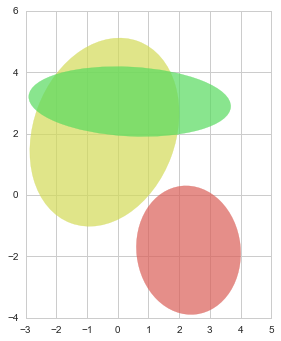

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.023982,0.009936,1.909749e-07,0.019172,0.127516,0.991788


GMM Plot Result
0.485784930465 [[ 2.25241762 -1.69810743]] [ 1.70468005  2.10555985] -176.221186146
0.387390708691 [[-0.56894871  2.09898738]] [ 2.08132139  3.21121512] 156.487402094
0.126824360844 [[ 0.16159985  3.17407974]] [ 1.31915887  3.45238821] -95.947251105


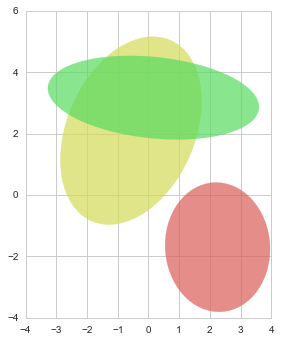

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.03152,0.011045,2.127431e-07,0.019438,0.134529,0.991019


GMM Plot Result
0.461368727429 [[-0.42094973  2.17707729]] [ 2.40990819  3.07341201] 158.803198529
0.456734222853 [[ 2.25109824 -1.80664646]] [ 1.73595806  2.07664615] -171.090302741
0.0818970497184 [[ 0.5411454   2.92029568]] [ 1.15955865  3.00407067] -94.0525205411


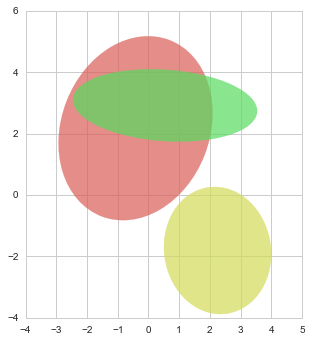

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021896,0.009519,2.149844e-07,0.019893,0.13513,0.990838


GMM Plot Result
0.537031709769 [[ 2.06955244 -1.5731179 ]] [ 1.78378654  2.19811688] -168.112487751
0.327592270074 [[-0.0846932   3.23462355]] [ 2.01745701  3.11059957] -87.9829319094
0.135376020157 [[-1.33021301  1.23541943]] [ 1.30529283  3.36284563] 157.737436707


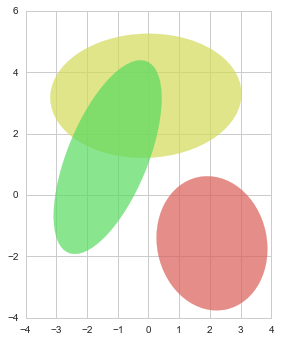

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.017764,0.009293,1.956863e-07,0.018896,0.129087,0.991578


GMM Plot Result
0.554137098429 [[-0.06658502  1.85007075]] [ 2.72008481  3.11095689] 168.882110456
0.389552210428 [[ 2.31327088 -1.93771148]] [ 1.66397483  2.02168662] -169.929997904
0.0563106911426 [[-0.08891131  2.93613175]] [ 1.00841181  2.21511021] -95.0431892753


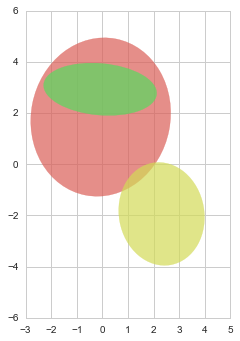

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.016758,0.009227,1.870176e-07,0.019009,0.126077,0.991935


GMM Plot Result
0.476622394261 [[ 2.23665417 -1.7751964 ]] [ 1.69747165  2.09680242] -172.460676474
0.396606357964 [[-0.53376874  2.1128205 ]] [ 2.11347751  3.18040742] 158.061919754
0.126771247775 [[ 0.20376985  3.0926778 ]] [ 1.34229674  3.48776287] -97.8031994517


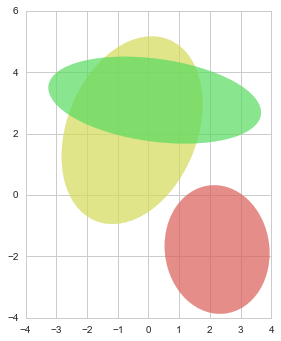

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022284,0.010008,1.689177e-07,0.017809,0.119937,0.992876


GMM Plot Result
0.483607978497 [[ 2.21668378 -1.71336679]] [ 1.72656829  2.10921479] -172.671473489
0.417603137395 [[-0.58284868  2.24714484]] [ 2.27329589  3.19975627] 158.592152315
0.0987888841086 [[ 0.68720552  2.99779176]] [ 1.17664109  3.07094432] -93.4188728084


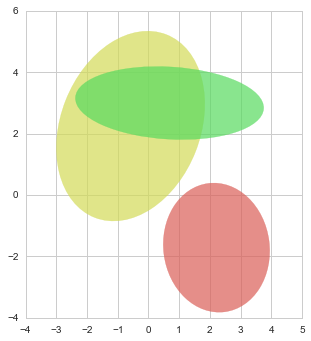

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.018881,0.00808,1.888521e-07,0.018405,0.126671,0.992022


In [61]:
for i in range(10):
    df_resampled = df.sample(frac=1, replace=True)
    result = fit_gmm(df_resampled, NUMBER_OF_GAUSSIAN, fit_method = FIT_METHOD)
    plot_gmm_ellipses(result['gmm'])
    display(pd.DataFrame(
        [goodness_of_fit_summary(result['gmm_pdf_result'], result['kde_result'])]))

## 6.2 Cross validation, to select the number of Gaussian

In [62]:
## 5-fold cross validation
gaussian_number_range = arange(1,7)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        CV_result_train.append(gof_train)
        CV_result_test.append(gof_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print 'Train'
    display(pd.DataFrame(CV_result_train))
    print 'Test'
    display(pd.DataFrame(CV_result_test))

Number of train/test dataset 30427.5 10142.5
  
Number of gaussian 1
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.085383,0.049694,0.000002,0.063787,0.427743,0.908144
1,0.086016,0.050652,0.000002,0.063143,0.434399,0.906810
2,0.084168,0.048295,0.000002,0.062084,0.421550,0.911377
3,0.085940,0.048617,0.000002,0.063217,0.423780,0.909457


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.084597,0.052964,0.000002,0.060970,0.424436,0.911356
1,0.095471,0.044167,0.000002,0.063312,0.407727,0.914096
2,0.094891,0.054896,0.000002,0.066125,0.443648,0.901241
3,0.086557,0.056855,0.000002,0.064455,0.449146,0.901992


  
Number of gaussian 2
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022728,0.015743,2.801780e-07,0.022407,0.154397,0.988213
1,0.025600,0.015843,2.790895e-07,0.022878,0.154121,0.988139
2,0.021888,0.015104,2.695314e-07,0.022467,0.151408,0.988457
3,0.020957,0.015654,2.683524e-07,0.022508,0.151090,0.988554


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029163,0.014342,3.416230e-07,0.026604,0.170470,0.985046
1,0.021768,0.023893,3.195608e-07,0.023992,0.164796,0.986427
2,0.023413,0.018213,3.257072e-07,0.024271,0.166541,0.986467
3,0.035475,0.013782,3.384766e-07,0.024454,0.169727,0.985773


  
Number of gaussian 3
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022438,0.009248,1.887079e-07,0.018914,0.126721,0.991935
1,0.019820,0.008926,1.936991e-07,0.018903,0.128370,0.991770
2,0.023320,0.009558,1.977326e-07,0.018930,0.129688,0.991652
3,0.018396,0.008947,1.825950e-07,0.018500,0.124642,0.992220


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029128,0.013387,2.664990e-07,0.021568,0.150529,0.988869
1,0.026313,0.010149,2.144579e-07,0.020145,0.135085,0.990874
2,0.024882,0.011834,2.177828e-07,0.020863,0.136165,0.990554
3,0.018552,0.010191,2.301887e-07,0.020377,0.139933,0.990286


  
Number of gaussian 4
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.012739,0.007936,8.603931e-08,0.012752,0.085512,0.996338
1,0.014698,0.005935,1.163161e-07,0.014690,0.099485,0.995065
2,0.011150,0.007482,8.314315e-08,0.012342,0.084142,0.996470
3,0.016479,0.006420,1.120934e-07,0.014396,0.097659,0.995224


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.016253,0.011605,1.276222e-07,0.014989,0.104366,0.994598
1,0.022124,0.008187,1.536436e-07,0.016905,0.114308,0.993437
2,0.019970,0.013643,1.356208e-07,0.016166,0.107278,0.994219
3,0.020019,0.009538,1.849817e-07,0.018646,0.125441,0.992198


  
Number of gaussian 5
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.006306,0.004492,5.210423e-08,0.009803,0.066586,0.997789
1,0.007266,0.003697,5.554908e-08,0.010258,0.068725,0.997614
2,0.006848,0.005873,6.285614e-08,0.010797,0.073140,0.997353
3,0.010843,0.005199,5.763879e-08,0.010279,0.070030,0.997546


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.012400,0.008128,1.196111e-07,0.015046,0.100851,0.994891
1,0.013797,0.006436,1.203331e-07,0.014510,0.101273,0.995042
2,0.010507,0.008939,1.238668e-07,0.015187,0.102604,0.994589
3,0.011840,0.006333,1.043128e-07,0.014184,0.094194,0.995588


  
Number of gaussian 6
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.009870,0.005371,4.913383e-08,0.009515,0.064629,0.997918
1,0.007834,0.004656,4.108603e-08,0.008763,0.059140,0.998248
2,0.008064,0.005920,4.886394e-08,0.009630,0.064469,0.997920
3,0.008077,0.004928,4.978770e-08,0.009512,0.065099,0.997886


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.013489,0.008446,1.133324e-07,0.014669,0.098313,0.995143
1,0.012594,0.015181,1.010868e-07,0.013561,0.092657,0.995750
2,0.010847,0.007765,9.587228e-08,0.012914,0.090348,0.995944
3,0.016426,0.011562,1.136298e-07,0.015004,0.098254,0.995157


In [63]:
mean_gof_train_all = generate_mean_gof(CV_result_train_all)
print 'Train mean gof'
display(mean_gof_train_all)

mean_gof_test_all = generate_mean_gof(CV_result_test_all)
print 'Test mean gof'
display(mean_gof_test_all)

Train mean gof


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.085377,0.049315,2.142029e-06,0.063058,0.426868,0.908947
1,0.022793,0.015586,2.742878e-07,0.022565,0.152754,0.988341
2,0.020994,0.009170,1.906837e-07,0.018812,0.127355,0.991894
3,0.013767,0.006943,9.939799e-08,0.013545,0.091699,0.995774
4,0.007816,0.004815,5.703706e-08,0.010284,0.069621,0.997576
5,0.008461,0.005219,4.721788e-08,0.009355,0.063334,0.997993


Test mean gof


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.090379,0.052221,2.188967e-06,0.063715,0.431239,0.907172
1,0.027455,0.017558,3.313419e-07,0.024830,0.167883,0.985928
2,0.024719,0.011390,2.322321e-07,0.020738,0.140428,0.990146
3,0.019591,0.010743,1.504670e-07,0.016677,0.112848,0.993613
4,0.012136,0.007459,1.170310e-07,0.014732,0.099731,0.995028
5,0.013339,0.010738,1.059803e-07,0.014037,0.094893,0.995499


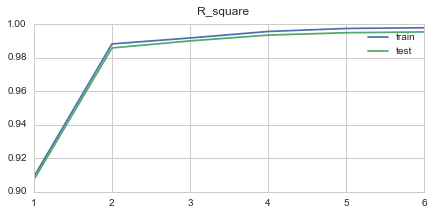

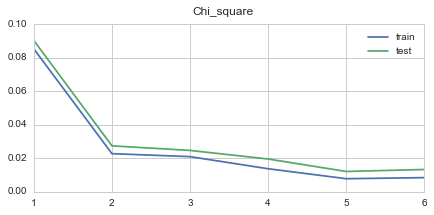

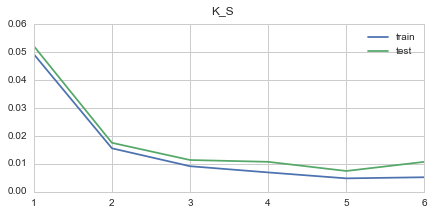

In [64]:
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, mean_gof_train_all[column],'-', label = 'train')
    plt.plot(gaussian_number_range, mean_gof_test_all[column],'-', label = 'test')
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.legend()
    plt.show()

## 6.3 Variance of KDE

In [65]:
sss

NameError: name 'sss' is not defined

In [ ]:
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    sub_df = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    sample = sub_speed_set = array(zip(sub_df.x, sub_df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    
    X = Y = PLOT_AXIS_RANGE
    kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    plot_2d_prob_density(X,Y,kde_Z,ax)
    plt.show()
#     plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir)

In [ ]:
## 5-fold cross validation
gaussian_number_range = arange(3,5)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_train = result['kde_clf']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        # Plot jPDF
        X = Y = PLOT_AXIS_RANGE
        kde_train_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_train.score_samples(coords)))
        fig = plt.figure(figsize=(22,6))
        ax1 = fig.add_subplot(1,3,1)
        plot_2d_prob_density(X,Y,kde_train_Z, ax1)
        
        ax2 = fig.add_subplot(1,3,2)
        kde_test_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_test.score_samples(coords)))
        plot_2d_prob_density(X,Y,kde_test_Z, ax2)
            
        ax3 = fig.add_subplot(1,3,3)
        plot_2d_prob_density(X,Y,kde_train_Z-kde_test_Z,ax3)
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        